In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import keras.backend as K
from keras.preprocessing.image import save_img
from sklearn.metrics import confusion_matrix,classification_report

Using TensorFlow backend.


In [3]:
Fraud = data[data['Class']==1]
Normal = data[data['Class']==0]
print("Fraud: ",len(Fraud))
print("total: ",len(data))
print("Fraud rate: ",round((len(Fraud)/len(data)),5))
Y = data['Class']
X = data.drop(['Class'],axis=1)

Fraud:  492
total:  284807
Fraud rate:  0.00173


In [5]:
Y = data['Class']
X = data.drop(['Class'],axis=1)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_train2, X_validate, y_train2, y_validate = train_test_split(X_train, Y_train, 
                                                            test_size=0.2, random_state=42)
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)
# trans = MinMaxScaler()
# X_train = trans.fit_transform(X_train)
# X_validate = trans.transform(X_validate)
# X_test = trans.transform(X_test)

In [12]:
from imblearn.over_sampling import SMOTE,ADASYN

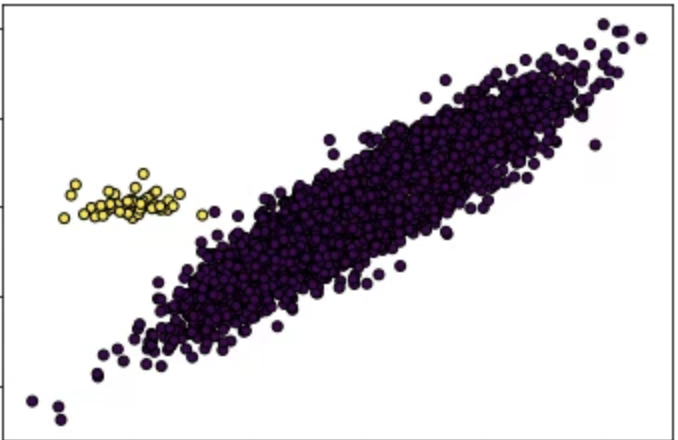
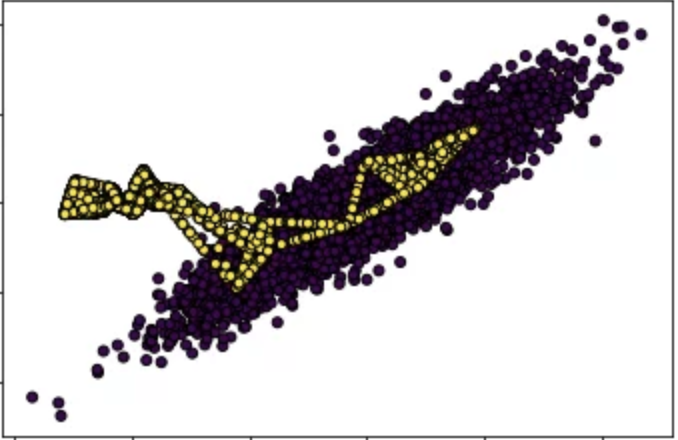
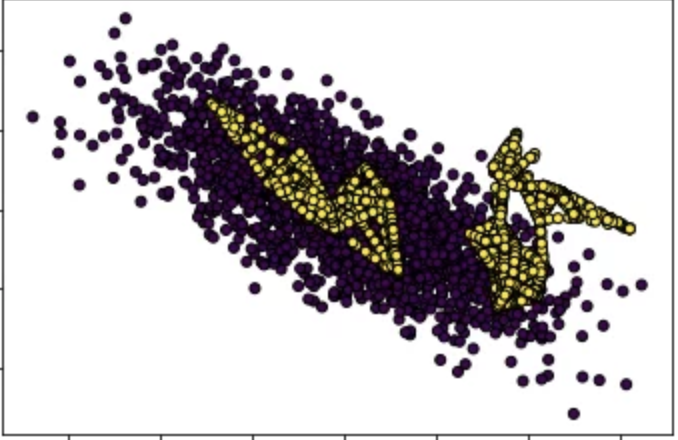

In [7]:
sm = SMOTE(random_state=42)
Xsm_train, ysm_train = sm.fit_sample(X_train, Y_train)
Xsm_validate, ysm_validate = sm.fit_sample(X_validate, y_validate)

ad = ADASYN(random_state=42)
Xad_train, yad_train = ad.fit_sample(X_train, Y_train)
Xad_validate, yad_validate = ad.fit_sample(X_validate, y_validate)

In [8]:
Xsm_train1 = Xsm_train.reshape(Xsm_train.shape[0],5,6,1)
X_test = X_test.reshape(X_test.shape[0],5,6,1)
Xsm_validate1 = Xsm_validate.reshape(Xsm_validate.shape[0],5,6,1)

Xad_train1 = Xad_train.reshape(Xad_train.shape[0],5,6,1)
# X_test = X_test.reshape(X_test.shape[0],5,6,1)
Xad_validate1 = Xad_validate.reshape(Xad_validate.shape[0],5,6,1)

X_validate = X_validate.reshape(X_validate.shape[0],5,6,1)

X_train1 = X_train.reshape(X_train.shape[0],5,6,1)

In [16]:
from keras.layers import GaussianNoise
# epochs = 10
model = Sequential()
model.add(Conv2D(32,(2,2),activation='relu', input_shape=Xsm_train1[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dropout(0.4))#0.2 - 0.5
model.add(Dense(128, activation='relu'))


model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 4, 5, 32)          160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 5, 32)          128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total para

In [21]:
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def fn(y_true, y_pred):
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return 1-fn

In [18]:
# without data augmentation

In [22]:
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=[fn])
History = model.fit(X_train1, Y_train,  
              epochs=10,
            validation_data=(X_validate, y_validate)
             )

Train on 227845 samples, validate on 45569 samples
Epoch 1/10
227845/227845 [==============================] - 18s 80us/step - loss: 0.0043 - fn: 0.9813 - val_loss: 0.0043 - val_fn: 0.9874
Epoch 2/10
227845/227845 [==============================] - 16s 71us/step - loss: 0.0038 - fn: 0.9822 - val_loss: 0.0044 - val_fn: 0.9860
Epoch 3/10
227845/227845 [==============================] - 17s 74us/step - loss: 0.0039 - fn: 0.9823 - val_loss: 0.0042 - val_fn: 0.9853
Epoch 4/10
227845/227845 [==============================] - 15s 67us/step - loss: 0.0038 - fn: 0.9816 - val_loss: 0.0039 - val_fn: 0.9867
Epoch 5/10
227845/227845 [==============================] - 14s 63us/step - loss: 0.0038 - fn: 0.9815 - val_loss: 0.0037 - val_fn: 0.9867
Epoch 6/10
227845/227845 [==============================] - 14s 64us/step - loss: 0.0036 - fn: 0.9836 - val_loss: 0.0040 - val_fn: 0.9881
Epoch 7/10
227845/227845 [==============================] - 16s 69us/step - loss: 0.0035 - fn: 0.9840 - val_loss: 0.0037 

Accuracy Score:  0.9995611109160493
Precision Score:  0.8947368421052632
Recall Score:  0.85
F1 score:  0.8717948717948718
False negative rate:  0.15


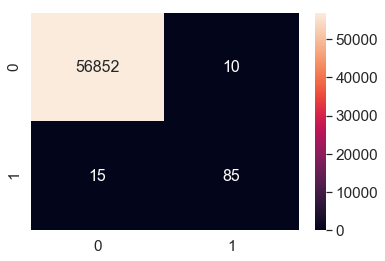

In [23]:
y_test_pred = model.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_test_pred.round()), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Accuracy Score: ",accuracy_score(Y_test, y_test_pred.round()))
print("Precision Score: ",precision_score(Y_test, y_test_pred.round()))
print("Recall Score: ",recall_score(Y_test, y_test_pred.round()))
print("F1 score: ",f1_score(Y_test, y_test_pred.round()))
print("False negative rate: ",df_cm[0][1]/(df_cm[0][1]+df_cm[1][1]))

In [13]:
# Smote

In [14]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
History = model.fit(Xsm_train1, ysm_train,  
              epochs=5,
            validation_data=(X_validate, y_validate)
             )

Train on 454906 samples, validate on 45569 samples
Epoch 1/5
454906/454906 [==============================] - 44s 96us/step - loss: 0.1063 - acc: 0.9689 - val_loss: 0.0370 - val_acc: 0.9894
Epoch 2/5
454906/454906 [==============================] - 44s 97us/step - loss: 0.0409 - acc: 0.9867 - val_loss: 0.0372 - val_acc: 0.9889
Epoch 3/5
454906/454906 [==============================] - 44s 97us/step - loss: 0.0321 - acc: 0.9898 - val_loss: 0.0261 - val_acc: 0.9924
Epoch 4/5
454906/454906 [==============================] - 39s 87us/step - loss: 0.0286 - acc: 0.9912 - val_loss: 0.0172 - val_acc: 0.9951
Epoch 5/5
454906/454906 [==============================] - 38s 83us/step - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0156 - val_acc: 0.9960


Accuracy Score:  0.9947333309925915
Precision Score:  0.23544973544973544
Recall Score:  0.89
F1 score:  0.3723849372384937
False negative rate:  0.11


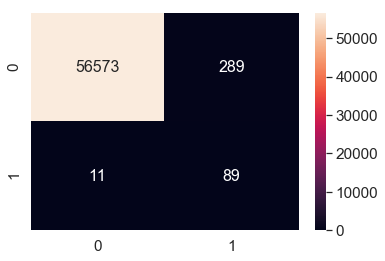

In [15]:
y_test_pred = model.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_test_pred.round()), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Accuracy Score: ",accuracy_score(Y_test, y_test_pred.round()))
print("Precision Score: ",precision_score(Y_test, y_test_pred.round()))
print("Recall Score: ",recall_score(Y_test, y_test_pred.round()))
print("F1 score: ",f1_score(Y_test, y_test_pred.round()))
print("False negative rate: ",df_cm[0][1]/(df_cm[0][1]+df_cm[1][1]))

In [16]:
# ADASYN

In [17]:
# model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
# History = model.fit(Xad_train1, yad_train,  
#               epochs=10,
#             validation_data=(X_validate, y_validate)
#              )

Train on 454938 samples, validate on 45569 samples
Epoch 1/10
454938/454938 [==============================] - 39s 86us/step - loss: 0.0395 - acc: 0.9892 - val_loss: 0.0406 - val_acc: 0.9894
Epoch 2/10
454938/454938 [==============================] - 38s 83us/step - loss: 0.0336 - acc: 0.9907 - val_loss: 0.0278 - val_acc: 0.9921
Epoch 3/10
454938/454938 [==============================] - 40s 88us/step - loss: 0.0315 - acc: 0.9913 - val_loss: 0.0297 - val_acc: 0.9912
Epoch 4/10
454938/454938 [==============================] - 40s 87us/step - loss: 0.0291 - acc: 0.9920 - val_loss: 0.0192 - val_acc: 0.9948
Epoch 5/10
454938/454938 [==============================] - 40s 87us/step - loss: 0.0282 - acc: 0.9924 - val_loss: 0.0254 - val_acc: 0.9934
Epoch 6/10
454938/454938 [==============================] - 39s 86us/step - loss: 0.0268 - acc: 0.9927 - val_loss: 0.0249 - val_acc: 0.9935
Epoch 7/10
454938/454938 [==============================] - 37s 81us/step - loss: 0.0259 - acc: 0.9929 - val_

Accuracy Score:  0.993153330290369
Precision Score:  0.1888412017167382
Recall Score:  0.88
F1 score:  0.3109540636042403
False negative rate:  0.12


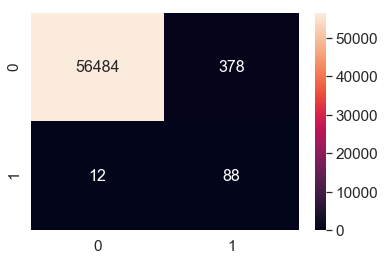

In [18]:
# y_test_pred = model.predict(X_test)
# df_cm = pd.DataFrame(confusion_matrix(Y_test, y_test_pred.round()), range(2),range(2))
# sns.set(font_scale=1.4)#for label size
# sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
# print("Accuracy Score: ",accuracy_score(Y_test, y_test_pred.round()))
# print("Precision Score: ",precision_score(Y_test, y_test_pred.round()))
# print("Recall Score: ",recall_score(Y_test, y_test_pred.round()))
# print("F1 score: ",f1_score(Y_test, y_test_pred.round()))
# print("False negative rate: ",df_cm[0][1]/(df_cm[0][1]+df_cm[1][1]))